In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scienceplots
from IPython.display import HTML
from matplotlib.animation import PillowWriter
from scipy.fft import fft2, ifft2, fftfreq, fftshift
import matplotlib.animation as anim
from matplotlib.colors import LinearSegmentedColormap

import pint 

In [2]:
plt.style.use(['science', 'notebook'])
u = pint.UnitRegistry()

## Computational Diffraction and Propagation of Ligth

We can write the propagation of the angular spectrum in terms of angular frequency by the following integral:
$$ U(x,y,z)=\int_{-\infty}^{+\infty}    \int_{-\infty}^{+\infty} A(k_x, k_y, 0) ~ e^{i(k_x x + k_y y)} ~ e^{\pm i z \sqrt{k^2-k_x^2-k_y^2} } ~ dk_x dk_y  $$

In terms of fourier transforms: 
$$\boxed{U(x,y,z) = \mathcal{F}^{-1}\left[A(k_x, k_y, 0) e^{- i z \sqrt{k^2-k_x^2-k_y^2} }\right]}$$

We may also write this equations in terms of spatial frequency as shown in many of the relevant literature: 
$$ U(x,y,z)=\int_{-\infty}^{+\infty}    \int_{-\infty}^{+\infty} A(f_x, f_y, 0) ~ e^{i2\pi(f_x x + f_y y)} ~ e^{\pm i z \sqrt{k^2-4\pi^2(f_x ^ 2 + f_y ^ 2)} } ~ df_x df_y  $$

In terms of the fourier transform:
$$\boxed{U(x,y,z) = \mathcal{F}^{-1}\left[A(f_x, f_y, 0) e^{- i z \sqrt{k^2-4\pi^2(f_x ^ 2 + f_y ^ 2)} }\right]}$$

k is defined as usual:

$$k = \omega/c = 2 \pi f / c = 2 \pi / \lambda$$

The term that depends on k is regarded as the transfer function of the system and it's sign indicates the direction of propagation of the light (- to the right, + to the left).

Either definition can be used. But it's preferable to use the definition in terms of angular frequency due to it's simplicity.

## Single Slit Experiment

In [3]:
# We define the parameters of the slit and the parameters of light
lam = 600 * u.nm
D = 0.1 * u.mm #Slit width
H = 1 * u.mm # Slit height

In [4]:
# We define an array to put the slit in
x = np.linspace(-2, 2, 1600) * u.mm 
X, Y = np.meshgrid(x, x)

We will denote the field $U(x, y, 0)$ as U0

In [5]:
U0 = ((np.abs(X) < D/2) * (np.abs(Y) < H/2 )).astype(float)

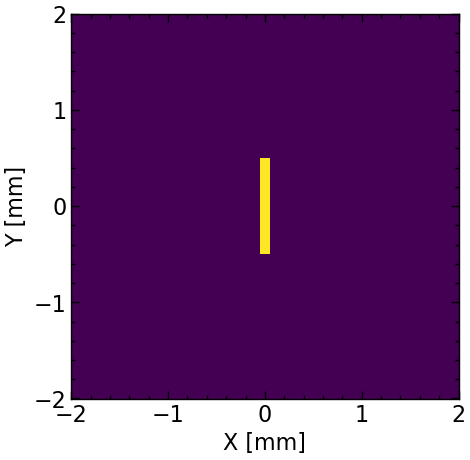

In [7]:
plt.figure(figsize=(5,5))
plt.pcolormesh(X,Y,U0)
plt.xlabel('X [mm]')
plt.ylabel('Y [mm]')
plt.show()

Now lets get the complex field $A(k_x, k_y, 0)$

In [8]:
A = fft2(U0)
kx = fftfreq(len(x), np.diff(x)[0]) * 2 * np.pi 
KX, KY = np.meshgrid(kx, kx)

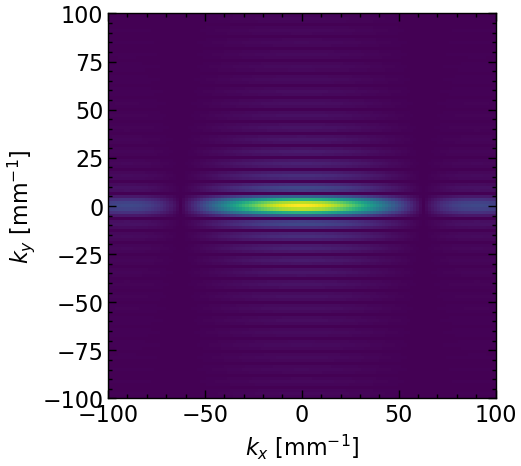

In [9]:
plt.figure(figsize=(5,5))
plt.pcolormesh(fftshift(KX.magnitude),fftshift(KY.magnitude),np.abs(fftshift(A)))
plt.xlabel('$k_x$ [mm$^{-1}$]')
plt.ylabel('$k_y$ [mm$^{-1}$]')
plt.xlim(-100,100)
plt.ylim(-100,100)
plt.show()

Now we can compute the propagated field in a given $U(x, y, z)$ at a given distance z from $U(x, y, 0)$

In [10]:
# We define the wave number k and distance from the slit
k = (2*np.pi) / lam
z = 3 * u.cm

In [11]:
U = ifft2(A*np.exp(-1j*z*np.sqrt((k**2) - (KX**2) - (KY**2))))

/home/haunted/miniconda3/envs/nm/lib/python3.12/site-packages/scipy/fft/_pocketfft/helper.py:98: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.array(x, dtype=dtype, copy=copy)


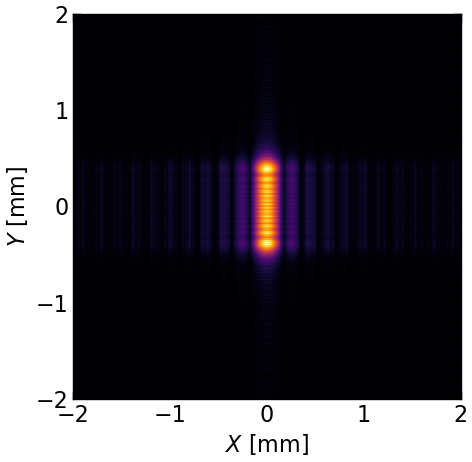

In [12]:
plt.figure(figsize=(5,5))
plt.pcolormesh(X,Y, np.abs(U), cmap='inferno')
plt.xlabel('$X$ [mm]')
plt.ylabel('$Y$ [mm]')
plt.show()

### Now we want to verify correctness of the solution
For the single slit experiment, minima of intensity occur at angles $\theta$ between the slit and the screen such that

$$D\sin\theta = m\lambda$$

where $D$ is the slit width and $m$ is a non-zero integer. By the pythagorean theorem:

$$\sin\theta = x/\sqrt{x^2 + d^2}$$

where $x$ is the horizontal distance on the screen and $d$ is the distance from the slit to screen, we can solve for the positions $x$ at minima:

$$x = \frac{m \lambda d}{\sqrt{D^2 - m^2 \lambda^2}}$$

In [13]:
m = np.arange(1, 5, 1)
x_min = ((m * lam * z) / np.sqrt(D**2 - (m**2)*(lam**2))).to('mm')

In [14]:
U.shape[0]/2

800.0

/home/haunted/miniconda3/envs/nm/lib/python3.12/site-packages/matplotlib/cbook.py:1345: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


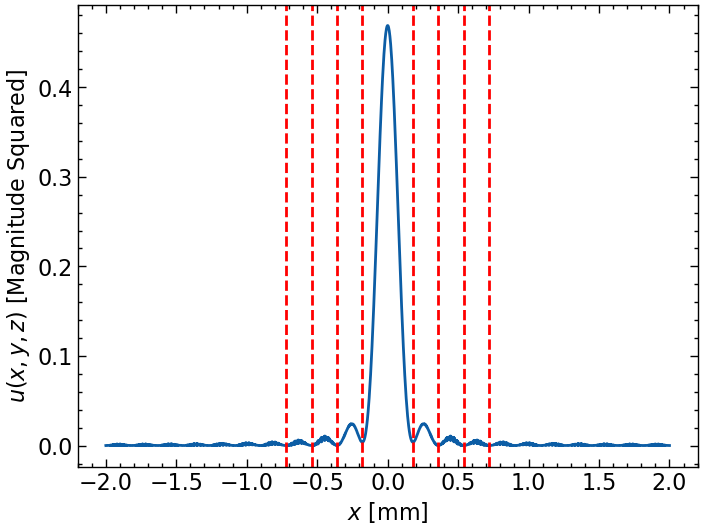

In [15]:
plt.plot(x, np.abs(U)[int(U.shape[0]/2)]**2)
[plt.axvline(x.magnitude, ls='--', color='r') for x in x_min]
[plt.axvline(-x.magnitude, ls='--', color='r') for x in x_min]
plt.xlabel('$x$ [mm]')
plt.ylabel('$u(x,y,z)$ [Magnitude Squared]')
plt.show()

### Now we define a function to automatically calculate the propagated field

In [16]:
def propagate(U0, X, Y, lam, z):
    x = X[0] # We get vectorial x
    k = (2 * np.pi) / lam 
    A = fft2(U0) # We calculate the DFT of the entrance field
    kx = fftfreq(len(x), np.diff(x)[0]) * 2 * np.pi # We get the angular frequencies in the freq domain
    KX, KY = np.meshgrid(kx, kx) # We generate a meshgrid for the frequencies
    
    return ifft2(A*np.exp(-1j*z*np.sqrt((k**2) - (KX**2) - (KY**2))))
    

## Arago's Spot Experiment

In [29]:
# We first define the parameters of the obstacle and the light
r = 0.2 * u.mm
l_r = 0.4 * u.mm #Láser radius
lam = 400 * u.nm

In [30]:
# Then we create the circular obstacle
x = np.linspace(-2, 2, 1600) * u.mm
X, Y  = np.meshgrid(x, x)

In [31]:
U0 = l_r**2 > X**2 + Y**2
U0 = (U0 * (r**2 < X**2 + Y**2)).astype(float)

In [32]:
z = 6 * u.cm
U = propagate(U0, X, Y, lam, z)

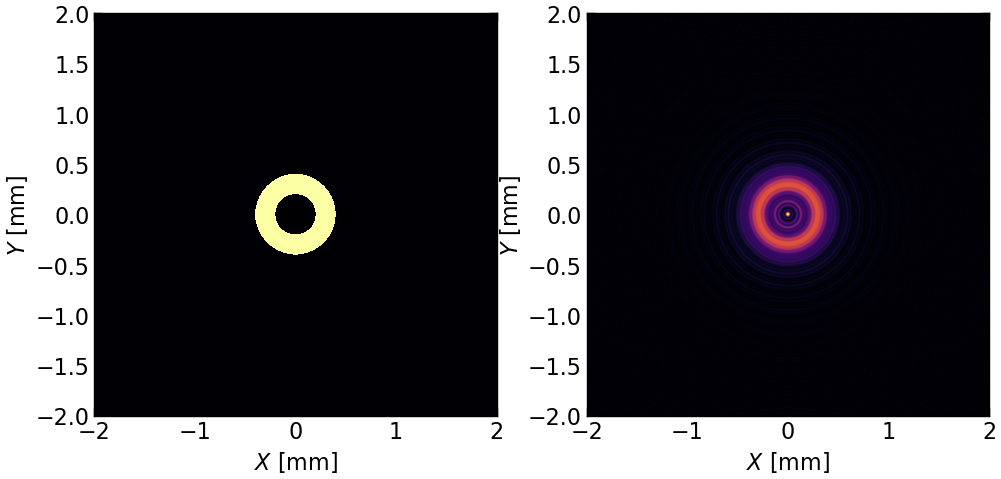

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].pcolormesh(X,Y,np.abs(U0), cmap="inferno")
ax[1].pcolormesh(X,Y,np.abs(U), cmap="inferno")

ax[0].set_xlabel('$X$ [mm]')
ax[0].set_ylabel('$Y$ [mm]')

ax[1].set_xlabel('$X$ [mm]')
ax[1].set_ylabel('$Y$ [mm]')

fig.tight_layout()

plt.show()

### We can also animate how the diffration pattern changes as we move the screen away from the obstacle

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.set_xlabel('$X$ [mm]')
ax.set_ylabel('$Y$ [mm]')

def animate(i):
    z = 0.05 * 2 * i * u.cm
    U = propagate(U0, X, Y, lam, z)
    #ax.imshow(np.abs(U), cmap='inferno')
    ax.pcolormesh(X,Y, np.abs(U), cmap='inferno')

ani = anim.FuncAnimation(fig, animate, frames=100, interval=50)

ani.save('argo2.gif',writer='pillow',fps=10,dpi=100)
#display(HTML(ani.to_jshtml()))


### Using a cmap that corresponds to the actual wavelenght

In [26]:
# This function maps wavelenght to actual rgb
def wavelength_to_rgb(wavelength, gamma=0.8):
    wavelength = float(wavelength)
    if wavelength >= 380 and wavelength <= 440:
        attenuation = 0.3 + 0.7 * (wavelength - 380) / (440 - 380)
        R = ((-(wavelength - 440) / (440 - 380)) * attenuation) ** gamma
        G = 0.0
        B = (1.0 * attenuation) ** gamma
    elif wavelength >= 440 and wavelength <= 490:
        R = 0.0
        G = ((wavelength - 440) / (490 - 440)) ** gamma
        B = 1.0
    elif wavelength >= 490 and wavelength <= 510:
        R = 0.0
        G = 1.0
        B = (-(wavelength - 510) / (510 - 490)) ** gamma
    elif wavelength >= 510 and wavelength <= 580:
        R = ((wavelength - 510) / (580 - 510)) ** gamma
        G = 1.0
        B = 0.0
    elif wavelength >= 580 and wavelength <= 645:
        R = 1.0
        G = (-(wavelength - 645) / (645 - 580)) ** gamma
        B = 0.0
    elif wavelength >= 645 and wavelength <= 750:
        attenuation = 0.3 + 0.7 * (750 - wavelength) / (750 - 645)
        R = (1.0 * attenuation) ** gamma
        G = 0.0
        B = 0.0
    else:
        R = 0.0
        G = 0.0
        B = 0.0
    #R *= 255
    #G *= 255
    #B *= 255
    return (R, G, B)

In [34]:
# We generate the personalized cmap
cmap_lam = LinearSegmentedColormap.from_list('custom', [(0,0,0),wavelength_to_rgb(lam.magnitude)], N=256)

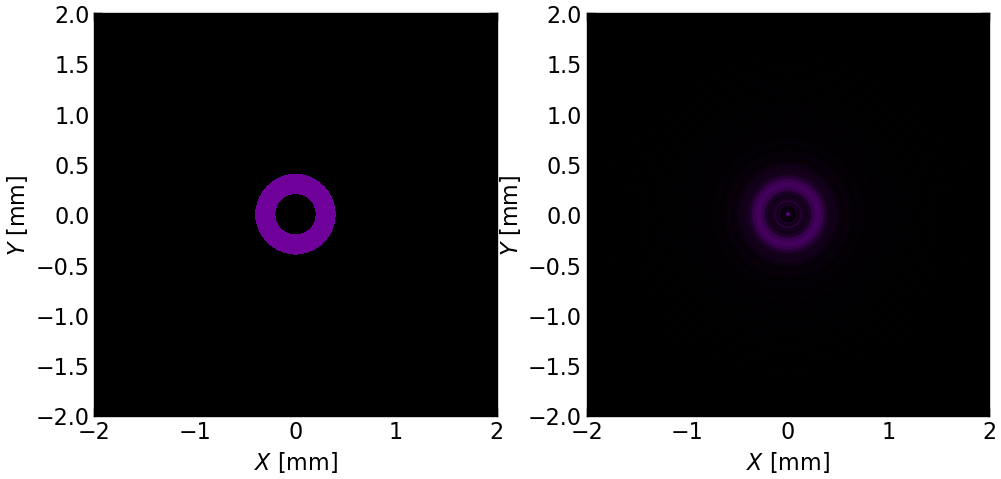

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].pcolormesh(X,Y,np.abs(U0), cmap=cmap_lam)
ax[1].pcolormesh(X,Y,np.abs(U), cmap=cmap_lam)

ax[0].set_xlabel('$X$ [mm]')
ax[0].set_ylabel('$Y$ [mm]')

ax[1].set_xlabel('$X$ [mm]')
ax[1].set_ylabel('$Y$ [mm]')

fig.tight_layout()

plt.show()